# Exploratory Data Analytics

In [1]:
!pip install geopandas

     |████████████████████████████████| 962kB 4.0MB/s 
     |████████████████████████████████| 10.9MB 368kB/s 
     |████████████████████████████████| 14.7MB 311kB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from scipy import stats

import re
import math

from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Importing Data

In [ ]:
auth.authenticate_user()

In [ ]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
worksheet = gc.open('Rice-Haryana').sheet1
rice_haryana = pd.DataFrame.from_records(worksheet.get_all_values())

## Data Cleaning


In [ ]:
# renaming columns
rice_haryana.columns = rice_haryana.loc[0,:]
rice_haryana.drop(0, inplace = True)

In [ ]:
# filling empty rows
rice_haryana.loc[rice_haryana['State/Crop/District'] == "", 'State/Crop/District'] = np.NaN
rice_haryana['State/Crop/District'] = rice_haryana['State/Crop/District'].fillna(method = 'ffill')

In [ ]:
# cleaning State/Crop/District columns
rice_haryana['State/Crop/District'] = rice_haryana['State/Crop/District'].apply(lambda x: re.findall('[a-zA-Z]+',x)[0])

In [ ]:
# checking for na values
rice_haryana.isna().sum()

0
State/Crop/District       0
Year                      0
Season                    0
Area (Hectare)            0
Production(Tonnes)        0
Yield (Tonnes/Hectare)    0
Temp Max (C)              0
Temp Min (C)              0
Rainfall (mm)             0
Wind Speed (m/s)          0
AET (mm)                  0
Soil Moisture (mm)        0
dtype: int64

In [ ]:
rice_haryana.head()

,State/Crop/District,Year,Season,Area (Hectare),Production(Tonnes),Yield (Tonnes/Hectare),Temp Max (C),Temp Min (C),Rainfall (mm),Wind Speed (m/s),AET (mm),Soil Moisture (mm)
1,AMBALA,1997-98,Kharif,65000,182000,2.8,32.775,22.3,190.75,1.2,122.5,128.5
2,AMBALA,1998-99,Kharif,71365,186000,2.61,32.9,23.85,194.5,1.1,127.75,136.75
3,AMBALA,1999-00,Kharif,72185,206000,2.85,33.75,23.675,137.25,1.275,117.75,75.5
4,AMBALA,2000-01,Kharif,71840,217000,3.02,33.675,23.25,139.75,1.175,113,113.25
5,AMBALA,2001-02,Kharif,74881,233000,3.11,33.75,23.65,117.75,1.15,104.25,88.5


In [ ]:
for index, col in rice_haryana.drop(['State/Crop/District','Year','Season'], axis = 1).iteritems():
  rice_haryana[index] = rice_haryana[index].astype(float)

In [ ]:
rice_haryana.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 1 to 300
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State/Crop/District     300 non-null    object 
 1   Year                    300 non-null    object 
 2   Season                  300 non-null    object 
 3   Area (Hectare)          300 non-null    float64
 4   Production(Tonnes)      300 non-null    float64
 5   Yield (Tonnes/Hectare)  300 non-null    float64
 6   Temp Max (C)            300 non-null    float64
 7   Temp Min (C)            300 non-null    float64
 8   Rainfall (mm)           300 non-null    float64
 9   Wind Speed (m/s)        300 non-null    float64
 10  AET (mm)                300 non-null    float64
 11  Soil Moisture (mm)      300 non-null    float64
dtypes: float64(9), object(3)
memory usage: 30.5+ KB


## Outlier Detection - Interquartile Range Method

Source:
1. https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
2. https://github.com/pandas-dev/pandas/issues/20944

### Production

Only look at lower cut-off for production as upper wouldn't make sense.

In [ ]:
# calculate interquartile range
q25, q75 = rice_haryana['Production(Tonnes)'].quantile(.25), rice_haryana['Production(Tonnes)'].quantile(.75)
iqr = q75 - q25
print('Percentiles: 25th = %.3f, 75th = %.3f, IQR = %.3f' % (q25, q75, iqr))

# calculate the outlier cutoff
cut_off = iqr * 1.5
lower = q25 - cut_off

Percentiles: 25th = 25750.000, 75th = 248250.000, IQR = 222500.000


In [ ]:
# identifying outliers
rice_haryana[rice_haryana['Production(Tonnes)'] < lower]

,State/Crop/District,Year,Season,Area (Hectare),Production(Tonnes),Yield (Tonnes/Hectare),Temp Max (C),Temp Min (C),Rainfall (mm),Wind Speed (m/s),AET (mm),Soil Moisture (mm)


## Univariate Analysis

Source:
1. https://github.com/jacobjohn2016/cs-notes/blob/master/Kaggle/Housing_Price_Prediction/house-price-prediction.ipynb

### Production

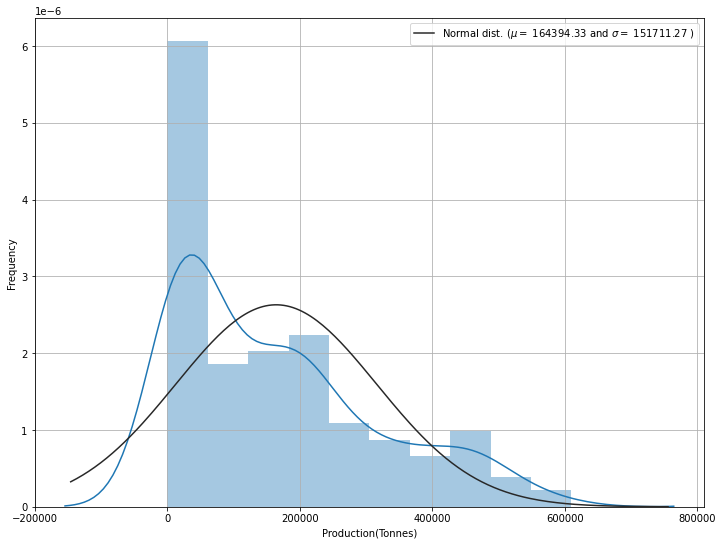

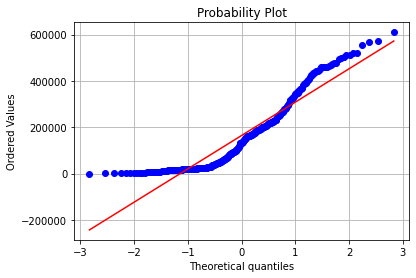

In [ ]:
plt.subplots(figsize=(12,9))
sns.distplot(rice_haryana['Production(Tonnes)'], fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(data = rice_haryana['Production(Tonnes)'])

# plot with the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.grid()

# Probablity plot
fig = plt.figure()
stats.probplot(rice_haryana['Production(Tonnes)'], plot=plt)
plt.grid()
plt.show()

### Area

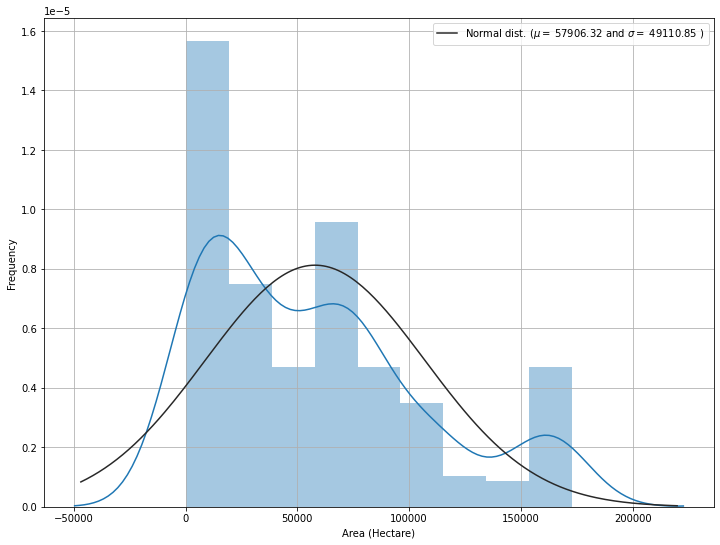

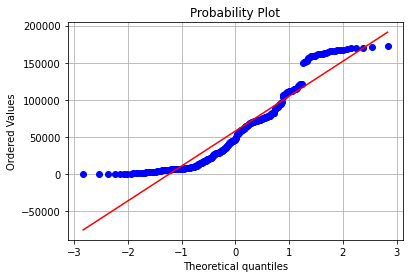

In [ ]:
plt.subplots(figsize=(12,9))
sns.distplot(rice_haryana['Area (Hectare)'], fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(data = rice_haryana['Area (Hectare)'])

# plot with the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.grid()

# Probablity plot
fig = plt.figure()
stats.probplot(rice_haryana['Area (Hectare)'], plot=plt)
plt.grid()
plt.show()

### Soil Moisture

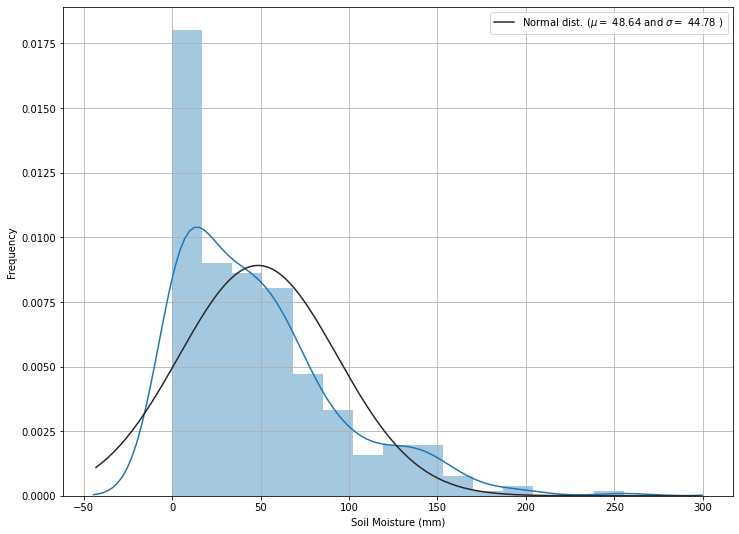

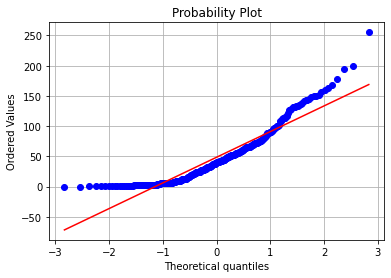

In [ ]:
plt.subplots(figsize=(12,9))
sns.distplot(rice_haryana['Soil Moisture (mm)'], fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(data = rice_haryana['Soil Moisture (mm)'])

# plot with the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.grid()

# Probablity plot
fig = plt.figure()
stats.probplot(rice_haryana['Soil Moisture (mm)'], plot=plt)
plt.grid()
plt.show()

### Rainfall

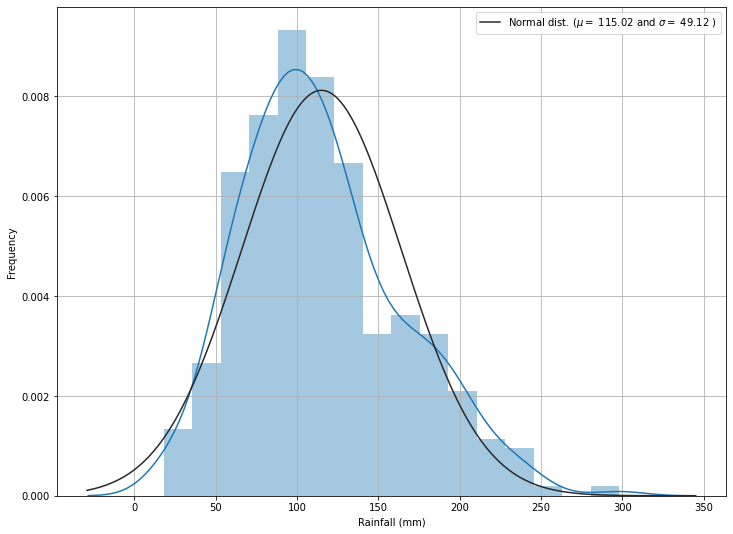

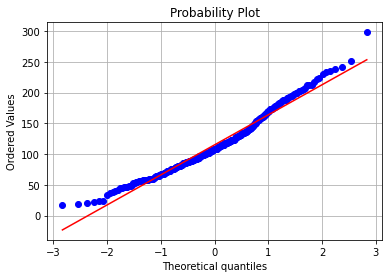

In [ ]:
plt.subplots(figsize=(12,9))
sns.distplot(rice_haryana['Rainfall (mm)'], fit=stats.norm)

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(data = rice_haryana['Rainfall (mm)'])

# plot with the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.grid()

# Probablity plot
fig = plt.figure()
stats.probplot(rice_haryana['Rainfall (mm)'], plot=plt)
plt.grid()
plt.show()

## Continuous-Continuous Bivariate Analysis

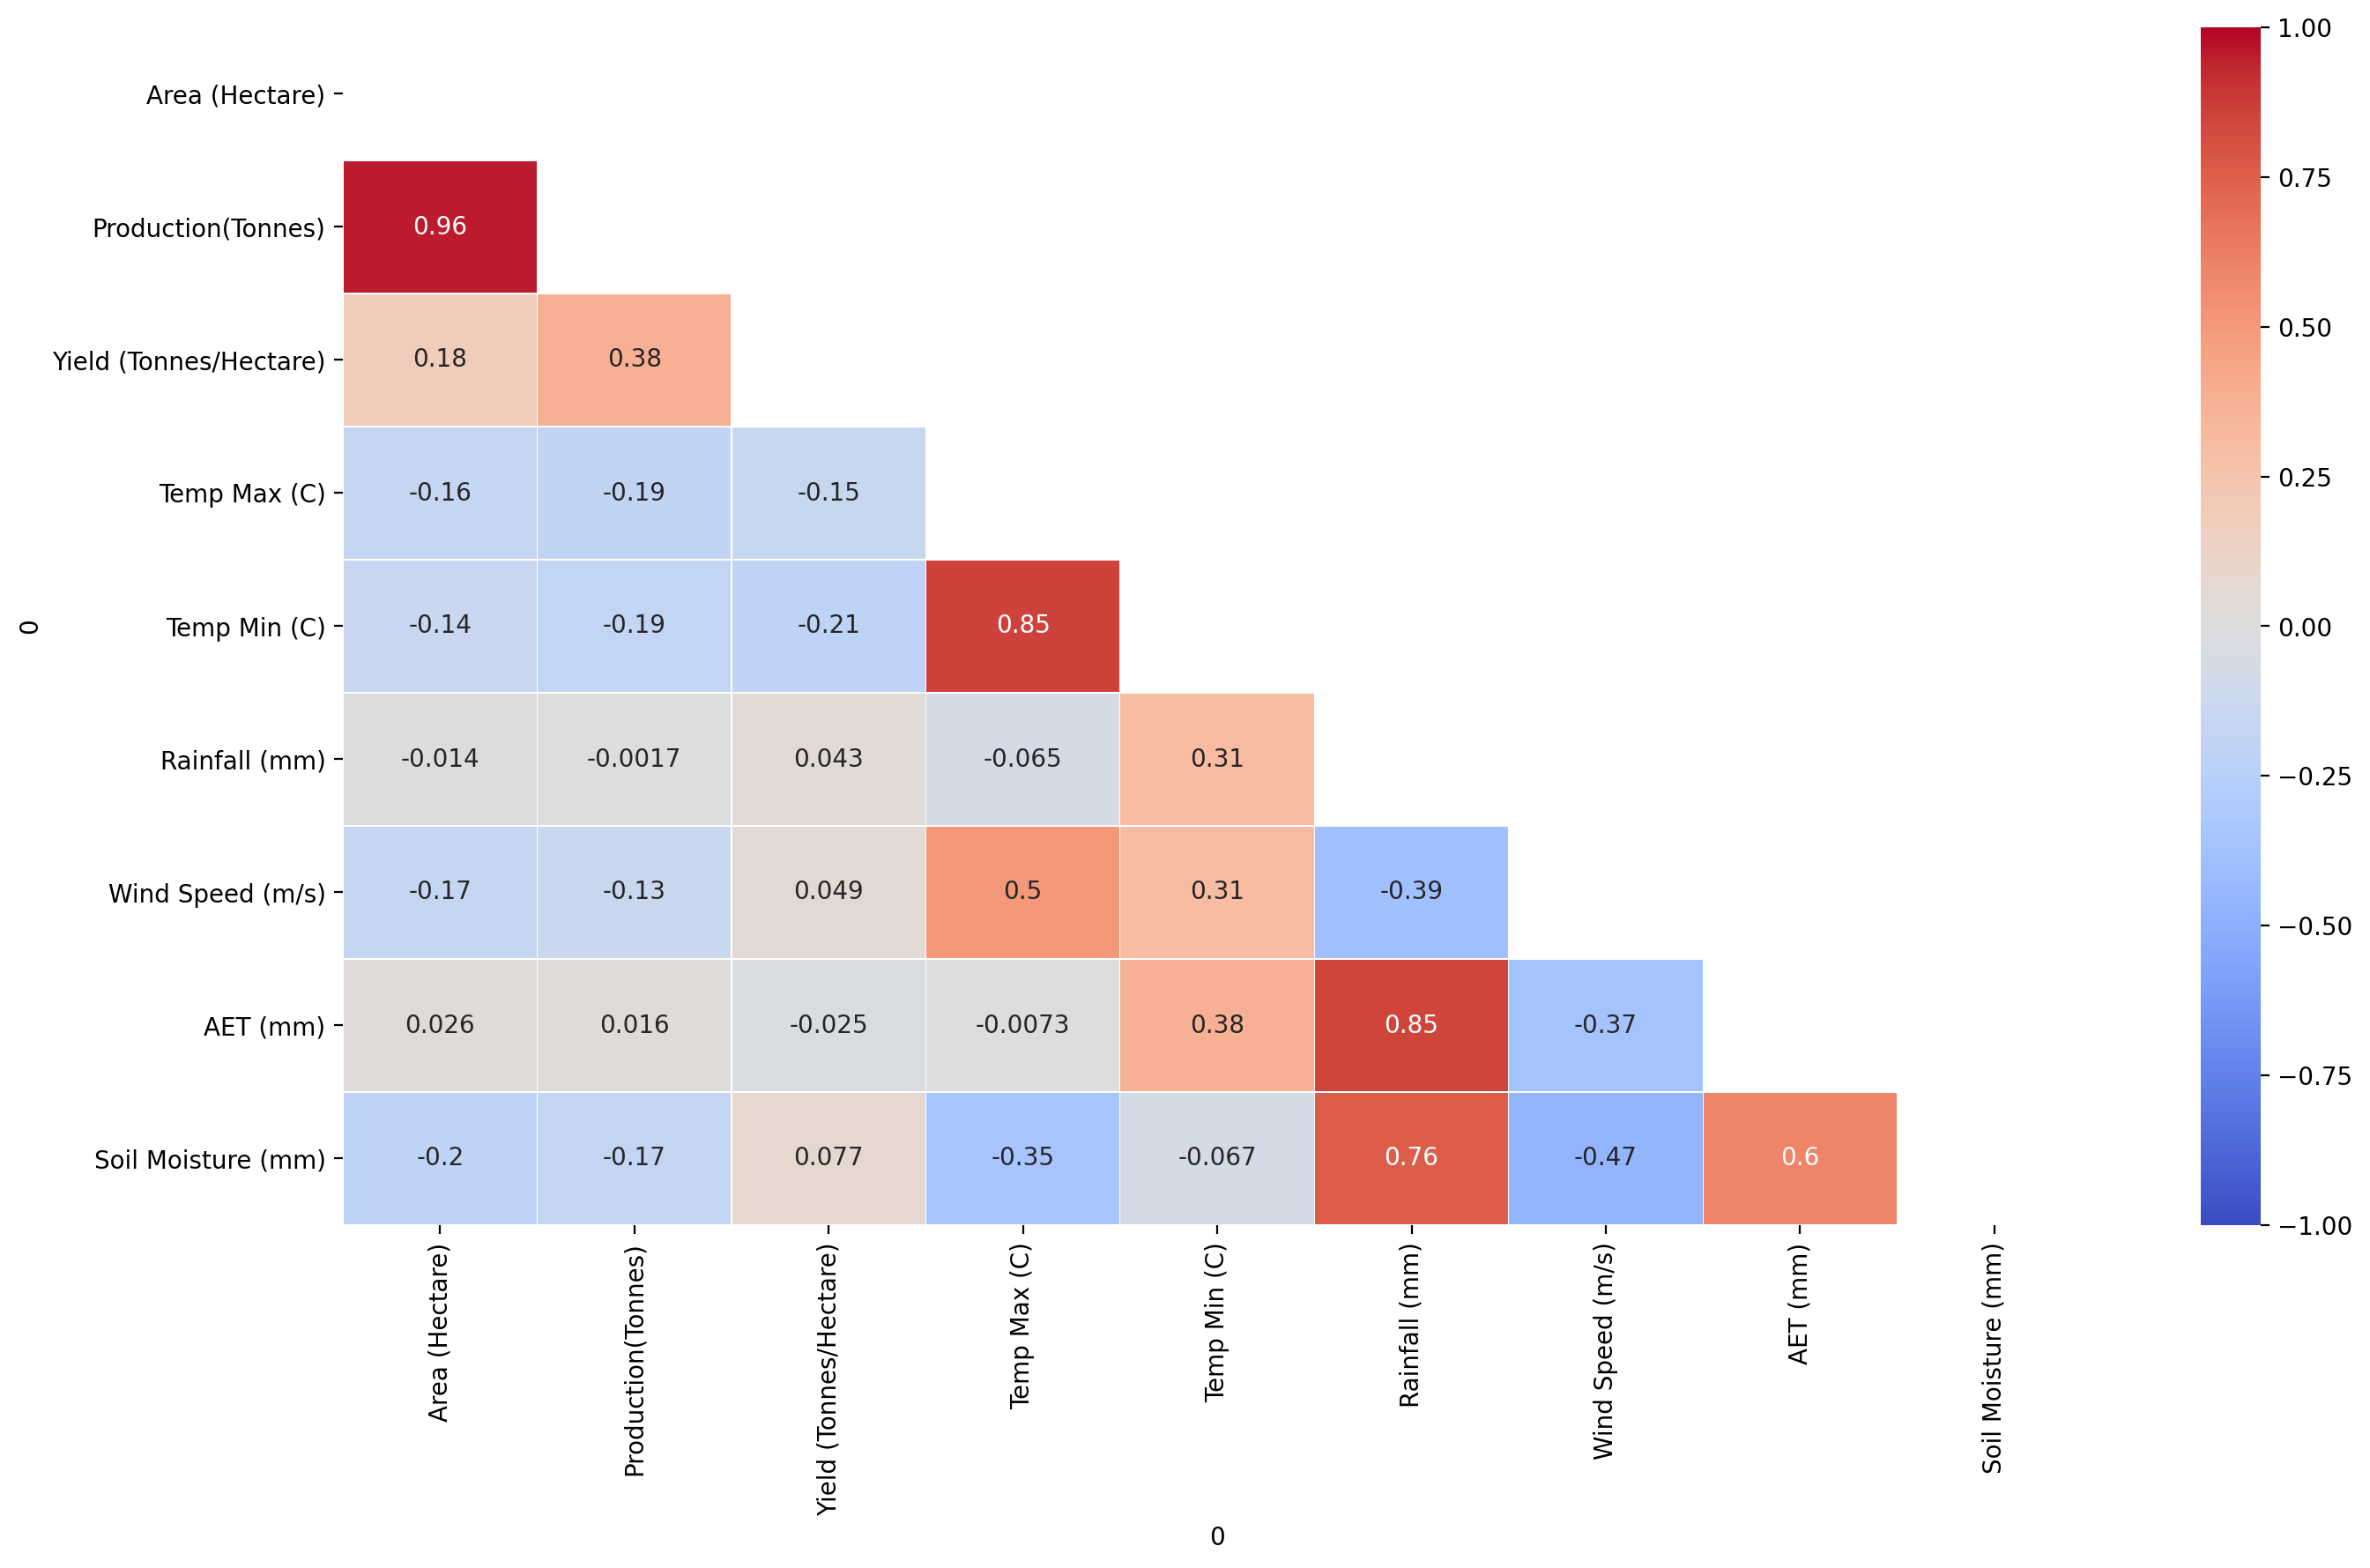

In [ ]:
plt.figure(figsize=(16, 9), dpi = 200)
corr_plot = rice_haryana.drop(['State/Crop/District','Year','Season'], axis = 1).corr()
mask = np.zeros_like(corr_plot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_plot,
            square=False, 
            linewidth=.1,
            vmin=-1,
            vmax=1,
            cmap='coolwarm',
            annot=True,
            mask = mask)
plt.show()

Since production and area are highly correlated, we'll need to use regularization.

## Categorical-Continuous Variable Analysis

### `State/Crop/District`

In [ ]:
hr_district_production = rice_haryana.groupby('State/Crop/District')['Production(Tonnes)'].median()
hr_district_production = hr_district_production.reset_index()

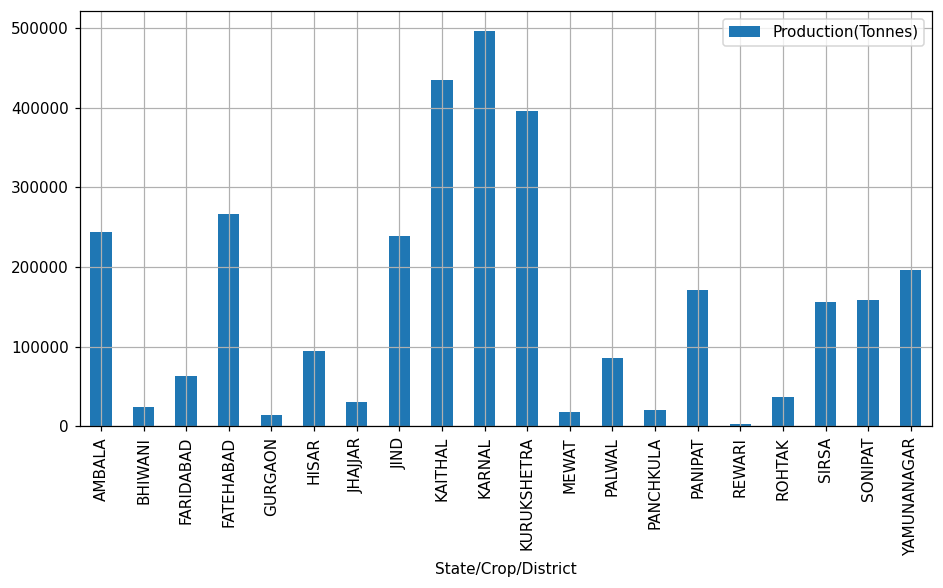

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 110)
hr_district_production.plot(x = 'State/Crop/District', y =  'Production(Tonnes)', kind = 'bar', ax = ax)
plt.grid()

In [ ]:
hr_district_yield = rice_haryana.groupby('State/Crop/District')['Yield (Tonnes/Hectare)'].median()
hr_district_yield = hr_district_yield.reset_index()

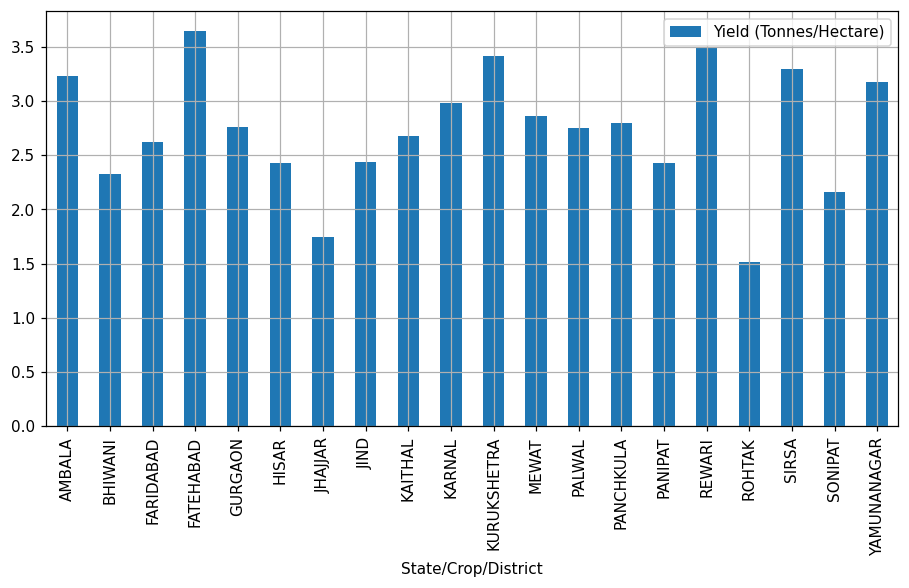

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 110)
hr_district_yield.plot(x = 'State/Crop/District', y =  'Yield (Tonnes/Hectare)', kind = 'bar', ax = ax)
plt.grid()

### Plotting States as a map

Sources:

1. https://gis.stackexchange.com/questions/300747/how-to-convert-geoseries-polygons-to-lists-of-coordinates
2. https://medium.com/starschema-blog/create-a-map-of-budapest-districts-colored-by-income-using-folium-in-python-8ab0becf4491
3. https://towardsdatascience.com/coloring-india-red-orange-and-green-covid19-choropleth-map-fc21a00f005f
4. https://stackoverflow.com/questions/51486454/convert-geopandas-shapely-polygon-to-geojson

In [3]:
# getting indian districts
india_districts = gpd.read_file('https://services1.arcgis.com/9H64STM3PyG3DqUs/arcgis/rest/services/' + 
                                'India_Districts_ADM2_GADM/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json')

In [4]:
india_districts.to_csv('india_districts.csv', index=False)

In [ ]:
haryana_districts = india_districts[india_districts.NAME_1 == 'Haryana']
haryana_districts.reset_index(drop = True, inplace = True)

In [ ]:
# getting latitude and longitudes of all states
haryana_districts.crs = {'init':'epsg:4326'}
haryana_districts['centroid_lon'] = haryana_districts['geometry'].centroid.x
haryana_districts['centroid_lat'] = haryana_districts['geometry'].centroid.y

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [ ]:
# merging with production data
hr_district_production['State/Crop/District'] = hr_district_production['State/Crop/District'].str.capitalize()
hr_district = pd.merge(hr_district_production, haryana_districts, left_on = 'State/Crop/District', right_on = 'NAME_2', how = 'left')\
[['State/Crop/District','Production(Tonnes)' ,'geometry','centroid_lon','centroid_lat']]

In [ ]:
# merging with yield data
hr_district_yield['State/Crop/District'] = hr_district_yield['State/Crop/District'].str.capitalize()
hr_district = pd.merge(hr_district_yield, hr_district, on = 'State/Crop/District')\
[['State/Crop/District','Production(Tonnes)','Yield (Tonnes/Hectare)' ,'geometry','centroid_lon','centroid_lat']]

In [ ]:
hr_district.head()

,State/Crop/District,Production(Tonnes),Yield (Tonnes/Hectare),geometry,centroid_lon,centroid_lat
0,Ambala,243500.0,3.235,"POLYGON ((77.07252 30.58105, 77.07688 30.57795...",76.966087,30.358540
1,Bhiwani,24000.0,2.325,"POLYGON ((76.00885 29.06304, 76.01419 29.06256...",75.957560,28.724096
2,Faridabad,63500.0,2.625,"POLYGON ((77.36396 28.49290, 77.36412 28.48565...",77.323141,28.164053
3,Fatehabad,267000.0,3.650,"POLYGON ((75.78320 29.81532, 75.79605 29.80712...",75.569089,29.579313
4,Gurgaon,14500.0,2.765,"POLYGON ((77.04877 28.51524, 77.05696 28.51386...",76.983476,28.168541


In [ ]:
def polygon_to_coords(geom):
  try:
    return list(geom.exterior.coords)
  except:
    return list()
    
def gdf_to_geojson(data):
    # create a geojson from a geo dataframe
    # containing coordinates with the name of the polygon
    # in our case a polygon is a district
    
    geojson = {
        "type": "FeatureCollection",
        "features": [
        {
            "type": "Feature",
            "geometry" : {
                "type": "Polygon",
                "name": district['State/Crop/District'],
                "coordinates": [polygon_to_coords(district['geometry'])],
                },
            "properties" : {'name': district['State/Crop/District']},
            
         } for index, district in data.iterrows()]
    }
    
    return geojson

#### Production Map

In [ ]:
hr_district = gpd.GeoDataFrame(hr_district, geometry = 'geometry')
hr_district.crs = {'init':'epsg:4326'}
hr_geojson = gdf_to_geojson(hr_district)
hr_district.columns = ['name','Production(Tonnes)','Yield (Tonnes/Hectare)' ,'geometry','centroid_lon','centroid_lat']

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
m = folium.Map(location = [hr_district['centroid_lat'].median(), hr_district['centroid_lon'].median()],
               zoom_start = 9)

In [ ]:
# add choropleth layer
m.choropleth(geo_data = hr_geojson,
             name = 'State-wise Production',
             data = hr_district,
             columns = ['name','Production(Tonnes)'],
             key_on = 'feature.geometry.name',
             legend = 'Production(Tonnes)',
             fill_color='YlGn')

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [ ]:
# add markers with basic information
fg = folium.FeatureGroup(name='District Info')
for lat, lon, val, name in zip(hr_district['centroid_lat'].tolist(),
                               hr_district['centroid_lon'].tolist(),
                               hr_district['Production(Tonnes)'].tolist(),
                               hr_district['name'].tolist()):
    if math.isnan(lat):
      continue
    html = f"""
    <h4>{name}<\h4><br>
    <p>Production: {int(round(val,0))} Tonnes <\p>
    """
    fg.add_child(folium.Marker(location=[lat, lon], tooltip=html))

m.add_child(fg)

# enable layers to be turned in or out
folium.LayerControl().add_to(m)

In [ ]:
m

In [ ]:
m.save('district_production.html')

#### Yield Map

In [ ]:
m = folium.Map(location = [hr_district['centroid_lat'].median(), hr_district['centroid_lon'].median()],
               zoom_start = 9)

In [ ]:
# add choropleth layer
m.choropleth(geo_data = hr_geojson,
             name = 'State-wise Production',
             data = hr_district,
             columns = ['name','Yield (Tonnes/Hectare)'],
             key_on = 'feature.geometry.name',
             legend = 'Yield (Tonnes/Hectare)',
             fill_color='YlGn')

/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [ ]:
# add markers with basic information
fg = folium.FeatureGroup(name='District Info')
for lat, lon, val, name in zip(hr_district['centroid_lat'].tolist(),
                               hr_district['centroid_lon'].tolist(),
                               hr_district['Yield (Tonnes/Hectare)'].tolist(),
                               hr_district['name'].tolist()):
    if math.isnan(lat):
      continue
    html = f"""
    <h4>{name}<\h4><br>
    <p>Yield: {int(round(val,0))} (Tonnes/Hectare) <\p>
    """
    fg.add_child(folium.Marker(location=[lat, lon], tooltip=html))

m.add_child(fg)

# enable layers to be turned in or out
folium.LayerControl().add_to(m)

In [ ]:
m

In [ ]:
m.save('district_yield.html')

## Mutating new variables


### State/District

* Two distinctive types of states - one set with a higher set of production than the other
* Take median and threshold each row belonging to a state as `High_Production_Area` or `Low_Production_Area`

In [ ]:
hr_district.loc[hr_district['Production(Tonnes)'] >= hr_district['Production(Tonnes)'].median(), 'Area_Type'] = 'High_Production_Area'
hr_district.loc[hr_district['Production(Tonnes)'] < hr_district['Production(Tonnes)'].median(), 'Area_Type'] = 'Low_Production_Area'

In [ ]:
rice_haryana['State/Crop/District'] = rice_haryana['State/Crop/District'].str.capitalize()

In [ ]:
rice_haryana.loc[rice_haryana['State/Crop/District']\
                 .isin(hr_district[hr_district['Area_Type'] == 'High_Production_Area']['name']), 'Area_Type'] = 'High_Production_Area'
rice_haryana.loc[rice_haryana['State/Crop/District']\
                 .isin(hr_district[hr_district['Area_Type'] == 'Low_Production_Area']['name']), 'Area_Type'] = 'Low_Production_Area'                 

### Temperature

Taking average

In [ ]:
rice_haryana['Temp (C)'] = (rice_haryana['Temp Max (C)'] - rice_haryana['Temp Min (C)'])/2

In [ ]:
rice_haryana.sample(5)

,State/Crop/District,Year,Season,Area (Hectare),Production(Tonnes),Yield (Tonnes/Hectare),Temp Max (C),Temp Min (C),Rainfall (mm),Wind Speed (m/s),AET (mm),Soil Moisture (mm),Area_Type,Temp (C)
11,Ambala,2007-08,Kharif,75164.0,277000.0,3.69,33.525,23.625,108.25,1.125,98.75,43.00,High_Production_Area,4.9500
71,Gurgaon,2003-04,Kharif,7491.0,19000.0,2.54,33.725,24.425,188.50,1.150,110.25,255.25,Low_Production_Area,4.6500
243,Rohtak,2003-04,Kharif,13859.0,21000.0,1.52,34.000,24.075,153.00,1.100,103.75,89.75,Low_Production_Area,4.9625
230,Rewari,2006-07,Kharif,788.0,3000.0,3.81,34.150,25.100,102.25,1.725,94.00,34.00,Low_Production_Area,4.5250
249,Rohtak,2009-10,Kharif,35056.0,50000.0,1.43,34.900,25.100,98.00,1.275,93.75,8.75,Low_Production_Area,4.9000



### Testing for independence

1. H0 : `Area_Type` and `Production` are independent. They have no
relationship, and the difference in production between the two
groups is due to chance. 
2. HA:  `Area_Type` and `Production` are not independent.
The difference in the production between the
two groups is not due
to chance and a `High_Production_Area` is associated with
an increase in production.

In [ ]:
_, p_value = ttest_ind(rice_haryana[rice_haryana['Area_Type'] == 'High_Production_Area']['Production(Tonnes)'],
                            rice_haryana[rice_haryana['Area_Type'] == 'Low_Production_Area']['Production(Tonnes)'])

In [ ]:
print(p_value < 0.05, p_value < 0.01)

True True


Since the p-value is below 0.01, this suggests that the actual results did not come from the independence model. That is, the vari-
ables do not appear to be independent, and we
reject the independence model in favor of the alternative. Hence, we can say with 99% confidence that a `High_Production_Area` is associated with higher production.

## Splitting into train and test

Source:
1. https://stackoverflow.com/questions/40901770/is-there-a-simple-way-to-change-a-column-of-yes-no-to-1-0-in-a-pandas-dataframe

In [ ]:
# dropping unnecessary variables
rice_haryana.drop(['State/Crop/District', 'Yield (Tonnes/Hectare)','Year', 'Season', 'AET (mm)', 'Wind Speed (m/s)', 'Temp Max (C)', 'Temp Min (C)'], 
                  axis = 1, inplace = True)

In [ ]:
# one hot encoding Area_Type
rice_haryana['Area_Type'] = pd.Series(np.where(rice_haryana['Area_Type'] == 'High_Yield_Area', 1, 0), rice_haryana.index)

In [ ]:
rice_haryana.sample(5)

,Area (Hectare),Production(Tonnes),Rainfall (mm),Soil Moisture (mm),Area_Type,Temp (C)
61,81385.0,291000.0,57.25,3.75,0,5.6000
114,110962.0,230000.0,108.50,9.00,0,4.6750
92,48567.0,132000.0,81.75,18.25,0,5.2250
178,8097.0,15000.0,114.50,50.00,0,4.3125
252,36432.0,55000.0,155.25,77.75,0,4.5500


In [ ]:
rice_haryana2 = rice_haryana.copy()

In [ ]:
rice_haryana['Production(Tonnes)'] = np.log(rice_haryana['Production(Tonnes)'])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
rice_haryana.replace([np.inf, -np.inf], 0, inplace=True)

In [ ]:
train, test = train_test_split(rice_haryana, test_size=0.20, stratify=rice_haryana['Area_Type'], random_state=1234)

In [ ]:
train_x = train.drop(['Production(Tonnes)'], axis = 1)
train_y = train[['Production(Tonnes)']]

test_x = test.drop(['Production(Tonnes)'], axis = 1)
test_y = test[['Production(Tonnes)']]

In [ ]:
train_x.head()

,Area (Hectare),Rainfall (mm),Soil Moisture (mm),Area_Type,Temp (C)
30,21314.0,135.50,52.00,0,4.6750
242,7412.0,63.75,13.25,0,4.4875
43,29214.0,111.25,36.25,0,4.3625
100,16498.0,86.00,41.50,0,5.2750
14,81869.0,212.50,127.00,0,4.5000


## Scaling the data

1. https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02?gi=324ac0dc3d85

In [ ]:
mm_scaler = preprocessing.MinMaxScaler()

In [ ]:
train_minmax = train_x.copy()
train_minmax.loc[:,['Area (Hectare)', 'Rainfall (mm)', 'Soil Moisture (mm)', 'Temp (C)']] = \
mm_scaler.fit_transform(train_x[['Area (Hectare)', 'Rainfall (mm)', 'Soil Moisture (mm)', 'Temp (C)']])

In [ ]:
test_minmax = test_x.copy()
test_minmax.loc[:,['Area (Hectare)', 'Rainfall (mm)', 'Soil Moisture (mm)', 'Temp (C)']] = \
mm_scaler.fit_transform(test[['Area (Hectare)', 'Rainfall (mm)', 'Soil Moisture (mm)', 'Temp (C)']])

## Linear Regression - Model & CV

Source:
1. https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
lreg = LinearRegression()

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [ ]:
scores = cross_val_score(lreg, train_minmax, train_y, cv=cv, scoring='neg_root_mean_squared_error')

In [ ]:
print("Neg RMSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Neg RMSE: -0.96 (+/- 0.79)


## Learning Curve

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    lreg, train_minmax, train_y, train_sizes=np.linspace(0.1, 1.0, 50), 
    cv=10, scoring = 'neg_root_mean_squared_error')

In [ ]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -valid_scores.mean(axis = 1)

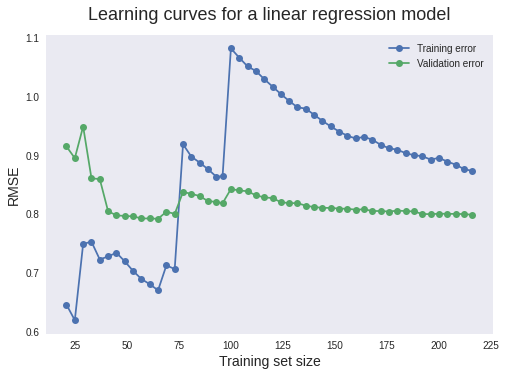

In [ ]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error', marker = 'o')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', marker = 'o')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.grid()
plt.legend()

* Seems like learning algorithm is experiencing high bias
* adding more training examples wouldn't help
* training and validation error are converging very quickly
* need more features/better features

## Regularization

Source:
1. https://scikit-learn.org/stable/modules/linear_model.html

In [ ]:
reg = RidgeCV(alphas=np.logspace(-6, 6, 13))

In [ ]:
reg.fit(train_minmax, train_y)

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [ ]:
reg.alpha_

0.1

alpha is very small, hence regularization doesn't seem to have an effect

In [ ]:
ridge_reg = Ridge(alpha=.1)

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    ridge_reg, train_minmax, train_y, train_sizes=np.linspace(0.1, 1.0, 50), 
    cv=10, scoring = 'neg_root_mean_squared_error')

In [ ]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -valid_scores.mean(axis = 1)

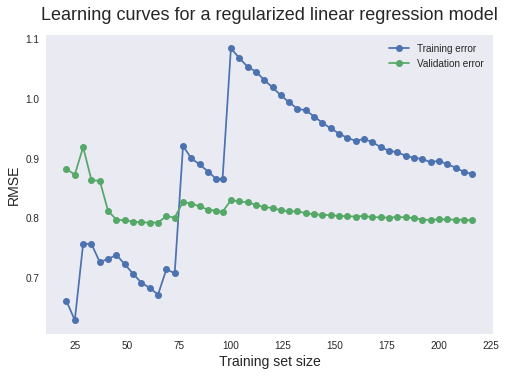

In [ ]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error', marker = 'o')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error', marker = 'o')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a regularized linear regression model', fontsize = 18, y = 1.03)
plt.grid()
plt.legend()